In [1]:
classes = ['0', '1', '2', '3', '4', '5', 'lt', 'gt']

In [2]:
from __future__ import print_function
import os
from shutil import copy2, rmtree
from typing import Callable, List
import numpy as np

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

In [3]:
import matplotlib.pyplot as plt

In [4]:
os.sys.path.append('..')
from utils import image_transpose_exif

In [133]:
class DigitsDataset(Dataset):
    """Custom digits dataset object for pytorch"""

    def __init__(self, 
                 img_dir_path: str, 
                 resize=None, 
                 transform: Callable=None, 
                 augmentation: Callable=None, 
                 copies: int=None,
                 model: bool=True):
        """
        Args:
            img_dir_path: Path to the csv file with annotations.
            transform: Optional transform to be applied
                on a sample.
        """
        self.img_dir_path = img_dir_path
        self.resize = resize
        self.transform = transform
        self.augmentation = augmentation
        self.copies = copies
        self.paths = self._get_image_paths()
        self.label_encoder = self._get_label_encoder()
        self.model = model
    
    def _get_image_paths(self):
        """Get paths of images in a given directory."""
        paths = os.listdir(self.img_dir_path)
        return [x for x in paths if x[-3:] in ['png', 'jpg']]
        
        
    def _get_label_encoder(self):
        """Get integer encoder for class labels"""
        all_labels = list(set([x.split('.')[0].split('_')[0] for x in self.paths]))
        le = LabelEncoder()
        le.fit(all_labels)
        return le
        
    def __len__(self):
        return len(self.paths)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if self.copies:
            idx = idx % self.grid_frame.shape[0]

        img_name = os.path.join(self.img_dir_path, self.paths[idx])
        
        image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        image = image_transpose_exif(image)
        
        if self.resize is not None:
            image = cv2.resize(image, (28, 28))
            # mask = mask.reshape((*mask.shape, 1))
        
        if self.model:
            image = image / 255
            image = torch.from_numpy(image)
            image = image.to(torch.double)
            image = image.unsqueeze(0)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = self.paths[idx].split('.')[0].split('_')[0]
        label = self.label_encoder.transform([label])[0]
        
        if self.augmentation:
            pass
            # sample = self.augmentation(image=image, mask=mask)
            # image, mask = sample['image'], sample['mask']
            
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [134]:
dig = DigitsDataset('../data/digit_operator_data/train', resize=True, model=True)

In [135]:
dat = dig[-8]

TypeError: Invalid dimensions for image data

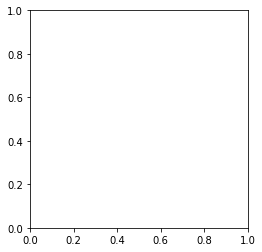

In [109]:
plt.imshow(dat[0])
print(dat[1])

In [136]:
dat[1]

2

In [18]:
class Net(nn.Module):
    def __init__(self, nclasses):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, nclasses)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [137]:
def train(model, device, train_loader, optimizer, epoch, log_interval, dry_run):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # import pdb; pdb.set_trace()
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

In [138]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [139]:
def split_heap(path: str, split_prop: float = 0.8, shuffle: bool = True):
    """Function to split the heap of digit operator data into train and test folders"""
    
    train_path = '../train/'
    test_path = '../test/'
    
    if os.path.exists(path + train_path):
        rmtree(path + train_path)
        
    if os.path.exists(path + test_path):
        rmtree(path + test_path)
        
    os.mkdir(path + train_path)
    os.mkdir(path + test_path)

    paths = os.listdir(path)
    paths = [x for x in paths if os.path.isfile(path + x)]
    np.random.shuffle(paths)
    
    num_train = int((len(paths) * split_prop))
    train = paths[:num_train]
    test = [x for x in paths if x not in train]
    
    _ = [copy2(path + x, path + train_path + x) for x in train]
    _ = [copy2(path + x, path + test_path + x) for x in test]
    

In [140]:
# split_heap('../data/digit_operator_data/heap/')

In [162]:
def main(classes: List[str],
         bs: int = 8, 
         test_bs: int = 1000, 
         epochs: int = 14, 
         lr: float = 1.0, 
         gamma: float = 0.7, 
         no_cuda: bool = False,
         dry_run: bool = False,
         seed: int = 1,
         log_interval: int = 10,
         save_model: bool = False):
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'batch_size': bs}
    
    if use_cuda:
        kwargs.update({'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True},
                     )

    # normalization and to_tensor handled in Dataset class 
    transform=None
    
    train_dataset = DigitsDataset('../data/digit_operator_data/train', resize=True, transform=transform)
    test_dataset = DigitsDataset('../data/digit_operator_data/test', resize=True, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, **kwargs)

    model = Net(len(classes))
    model = model.double()
    model.to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)  # TODO review optimiser

    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, log_interval, dry_run)
        test(model, device, test_loader)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")
        
    return model

In [145]:
temp_classes = ['0', '2', 'gt', 'lt']

In [146]:
mod = main(temp_classes)

Train Epoch: 1 [0/52 (0%)]	Loss: 1.328374

Test set: Average loss: 1.3319, Accuracy: 8/13 (62%)

Train Epoch: 2 [0/52 (0%)]	Loss: 1.215285

Test set: Average loss: 1.1500, Accuracy: 9/13 (69%)

Train Epoch: 3 [0/52 (0%)]	Loss: 0.863215

Test set: Average loss: 1.0951, Accuracy: 9/13 (69%)

Train Epoch: 4 [0/52 (0%)]	Loss: 0.721511

Test set: Average loss: 1.0401, Accuracy: 9/13 (69%)

Train Epoch: 5 [0/52 (0%)]	Loss: 0.590217

Test set: Average loss: 1.0367, Accuracy: 9/13 (69%)

Train Epoch: 6 [0/52 (0%)]	Loss: 0.530828

Test set: Average loss: 1.0419, Accuracy: 9/13 (69%)

Train Epoch: 7 [0/52 (0%)]	Loss: 0.391948

Test set: Average loss: 1.0223, Accuracy: 9/13 (69%)

Train Epoch: 8 [0/52 (0%)]	Loss: 0.270508

Test set: Average loss: 1.0092, Accuracy: 9/13 (69%)

Train Epoch: 9 [0/52 (0%)]	Loss: 0.254513

Test set: Average loss: 0.9984, Accuracy: 9/13 (69%)

Train Epoch: 10 [0/52 (0%)]	Loss: 0.213802

Test set: Average loss: 0.9948, Accuracy: 9/13 (69%)

Train Epoch: 11 [0/52 (0%)]	L

In [149]:
test_dataset = DigitsDataset('../data/digit_operator_data/test', resize=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [158]:
test_dataset[0][1]

0

In [159]:
mod(test_dataset[0][0].unsqueeze(0)).argmax()

tensor(0)